In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import *
from itertools import repeat
import re
from math import factorial

In [2]:
def extract_data(list_of_files_paths):
    """
    This function receives a list of paths of files I want to extract and to present together,
    and it returns a list of datafeames for these paths.
    """
    list_of_dfs=[]
    for path in list_of_files_paths:
        try:
            raw_data=pd.read_csv(path, delimiter=',',skiprows=1, header=None)
            raw_data_transposed=raw_data.transpose()
            if np.isfinite(raw_data).all().all():
                list_of_dfs.append(raw_data)
            else:
                print('not all the values are finite in file:', path)  
        except:
            print('problem with extracting :', path)
    return list_of_dfs

list_of_paths=['C:/Python/Recordings/CA3-minis_2.csv']                   
list_of_dfs=extract_data(list_of_paths)
assert isinstance(list_of_dfs,list)

In [3]:
def convert_dfs_to_numpy(list_of_dfs):
    list_of_nps=[]
    for i,df in enumerate(list_of_dfs):
        df=df.as_matrix()
        print('the type of element number', i+1, 'is', type(df), 'of shape:', (np.transpose(df)).shape)
        list_of_nps.append(np.transpose(df))
    return list_of_nps
            
list_of_nps=convert_dfs_to_numpy(list_of_dfs) 
assert isinstance(list_of_nps, list)

the type of element number 1 is <class 'numpy.ndarray'> of shape: (4, 1810000)


In [4]:
def savitzky_golay(y, window_size, order, deriv=0, rate=1): 
    """Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
   3     The Savitzky-Golay filter removes high frequency noise from data.
   4     It has the advantage of preserving the original shape and
   5     features of the signal better than other types of filtering
   6     approaches, such as moving averages techniques.
   7     Parameters
   8     ----------
   9     y : array_like, shape (N,)
  10         the values of the time history of the signal.
  11     window_size : int
  12         the length of the window. Must be an odd integer number.
  13     order : int
  14         the order of the polynomial used in the filtering.
  15         Must be less then `window_size` - 1.
  16     deriv: int
  17         the order of the derivative to compute (default = 0 means only smoothing)
  18     Returns
  19     -------
  20     ys : ndarray, shape (N)
  21         the smoothed signal (or it's n-th derivative).
  22     Notes
  23     -----
  24     The Savitzky-Golay is a type of low-pass filter, particularly
  25     suited for smoothing noisy data. The main idea behind this
  26     approach is to make for each point a least-square fit with a
  27     polynomial of high order over a odd-sized window centered at
  28     the point.
  29     Examples
  30     --------
  31     t = np.linspace(-4, 4, 500)
  32     y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
  33     ysg = savitzky_golay(y, window_size=31, order=4)
  34     import matplotlib.pyplot as plt
  35     plt.plot(t, y, label='Noisy signal')
  36     plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
  37     plt.plot(t, ysg, 'r', label='Filtered signal')
  38     plt.legend()
  39     plt.show()
  40     References
  41     ----------
  42     .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
  43        Data by Simplified Least Squares Procedures. Analytical
  44        Chemistry, 1964, 36 (8), pp 1627-1639.
  45     .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
  46        W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
  47        Cambridge University Press ISBN-13: 9780521880688
    """
    try:
           window_size = np.abs(np.int(window_size))
           order = np.abs(np.int(order))
    except (ValueError, msg):
            raise ValueError("window_size and order have to be of type int")
            if (window_size % 2 != 1) or (window_size < 1):
                raise TypeError("window_size size must be a positive odd number")
            if window_size < order + 2:
                raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

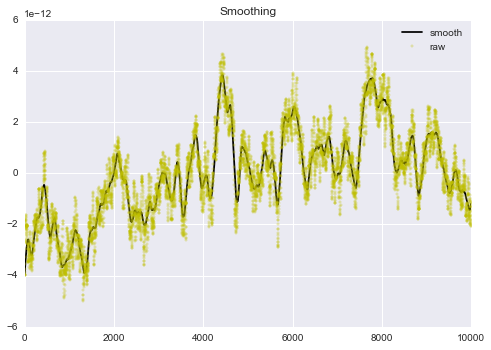

In [45]:
def smoothing_function(numpy_array):
    """
    this function takes the raw data as a numpy array with dimensions(number of time points, number of traces)
    and returns a numpy-array with same dimensions but after smoothing
    """
    smooth_array=np.zeros((len(numpy_array), len(numpy_array[0])))
    #print(smooth_array)
    for i,j in enumerate(numpy_array):
        smooth_array[i,:]=savitzky_golay(j, len(j)*0.0002, 4)
    return smooth_array
  
smooth=smoothing_function(list_of_nps[0]);
assert len(smooth) == len(list_of_nps[0])


#To see how the smoothing works:

plt.plot(smooth[0,:10000], color='k', label='smooth');
plt.plot(list_of_nps[0][0,:10000],'o', color='y', markersize=3, label='raw', alpha=0.3);
plt.title('Smoothing');
plt.legend();



In [46]:
def find_deriv(numpy_array):
    """
    This function takes a numpyarray and the derivative factor for each row in the matrix.
    Note that the derivative vector is of length n-1. 
    """
    deriv_matrix=np.zeros((len(numpy_array), len(numpy_array[0])-1))
    for i,row in enumerate(numpy_array):
        deriv_matrix[i,:]= row[1:len(row)]-row[:len(row)-1]
    return deriv_matrix

deriv_matrix=find_deriv(smooth)
assert len(deriv_matrix[0])+1 == len(smooth[0])
print(deriv_matrix.shape, smooth.shape)
        

(4, 1809999) (4, 1810000)


In [47]:
def detect_change_of_sign(numpy_array):
    """
    This function receives a numpy array and returns the loccations where the values 
    change from positive to negative or vice-versa.
    """
    bool_matrix=np.zeros((len(numpy_array), len(numpy_array[0])-1))
    Peaks_locations_list=[]
    for i,trace in enumerate(numpy_array):
        positive=trace>=0
        negative=trace<0
        bool_matrix[i,:]=positive[1:len(trace)] == negative[:len(trace)-1]
        bool_matrix=bool_matrix == 1
        print('The number of peaks in trace #',i+1,': ',bool_matrix[i,:].sum())
        Peaks_locations=np.arange((len(trace)))[bool_matrix[i,:]] 
        Peaks_locations_list.append(Peaks_locations)
        assert(len(Peaks_locations) == bool_matrix[i,:].sum()) # the number of locations is equal to the number of true values in the boolean array.   
    bool_matrix=bool_matrix == 1
    return bool_matrix, Peaks_locations_list

Peaks, Peaks_locations_list=detect_change_of_sign(deriv_matrix);# Peaks is a numpy matrix of booleans! 



The number of peaks in trace # 1 :  45026
The number of peaks in trace # 2 :  50111
The number of peaks in trace # 3 :  49774
The number of peaks in trace # 4 :  41700


In [48]:
# Create a list of locations array of peaks for every trace.
list_of_locations=[]
for i,row in enumerate(Peaks):
    locations=np.arange(len(row))[Peaks[i]]
    list_of_locations.append(locations) 

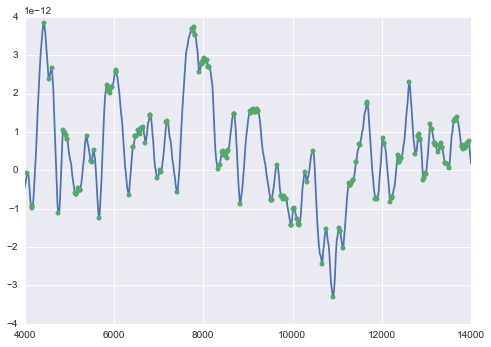

In [49]:

#To see an example of the peaks detection:

locations= (list_of_locations[0]> 4000) & (list_of_locations[0]< 14000)
locations=(list_of_locations[0][locations])
plt.plot(np.array(range(4000,14000)), smooth[0][4000:14000])
plt.plot(locations, smooth[0][locations], 'o', markersize=5)



In [50]:
#find the delta between the peaks:
Peaks_delta=[]
for i, trace in enumerate(smooth):
    smooth_peaks=np.zeros(len(Peaks[i])); # initialize the array for the peaks values.
    smooth_peaks=(trace[Peaks[i]]);
    assert (len(smooth_peaks) == len(trace[Peaks[i]]-1)) # the length of the delta vactor has to be 1 element shorter than the original vector.   
    Peaks_delta.append(smooth_peaks[1:len(smooth_peaks)] - smooth_peaks[:len(smooth_peaks)-1]);
    # append the array of the deltas of the peaks to a list of arrays. 

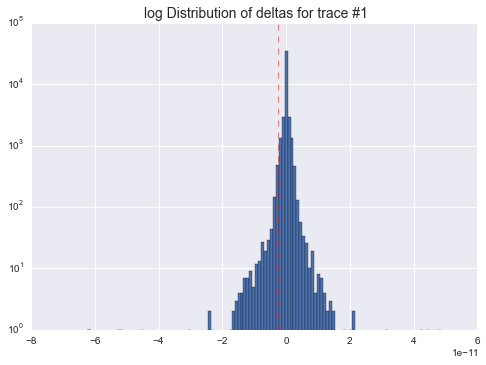

In [51]:
plt.hist(Peaks_delta[0],120, log=True);
plt.title('log Distribution of deltas for trace #1', fontsize=14);
plt.axvline(-0.25e-11, color='r',  alpha=0.5, linewidth=1, linestyle='--' );

In [52]:
def find_significant_changes_between_peaks(delta_values, Peaks_locations, threshold=-0.25e-11):
    sig_delta_values=[]
    loc_sig_delta_values=[]
    sig_delta_values_boolean=[]
    for i,trace in enumerate(delta_values):
        sig_delta_values_boolean.append((trace < threshold) & (trace > -3e-10))
        sig_delta_values.append(delta_values[i][sig_delta_values_boolean[i]]) # append the delta values where they are smaller than threshold...
        #print('delta_values:', len(trace), 'condition delta_values:',len((trace <= threshold) & (trace > -3e-10)),'Peaks_locations:', len(Peaks_locations[i]), 'sig_delta_values[i])',len(sig_delta_values[i]))
        loc_sig_delta_values.append(Peaks_locations[i][sig_delta_values_boolean[i]])
    return sig_delta_values, loc_sig_delta_values, sig_delta_values_boolean

sig_delta_values, loc_sig_delta_values, sig_delta_values_boolean=find_significant_changes_between_peaks(Peaks_delta, Peaks_locations_list)

In [38]:
peaks_boolean=[]
for i,boolean in enumerate(sig_delta_values_boolean):
    #print('1', len(sig_delta_values_boolean[i]))
    sig_delta_values_boolean[i]=boolean[0:len(boolean)-1]
    #print('2', len(sig_delta_values_boolean[i]))
    sig_delta_values_boolean[i]=np.hstack(( np.array(False), sig_delta_values_boolean[i]))
    #print('3', len(sig_delta_values_boolean[i]))
    peaks_boolean.append(sig_delta_values_boolean[i])
new_peaks_locations_list=[]
for i in range(len(Peaks)):
    assert len(loc_sig_delta_values[i]) == len(Peaks_locations_list[i][peaks_boolean[i]])
    new_peaks_locations_list.append(Peaks_locations_list[i][peaks_boolean[i]])

    

In [39]:
print(loc_sig_delta_values[0][0:20])
print(new_peaks_locations_list[0][0:20])

[ 4462  5955  8048 10403 17122 26382 33806 37838 45225 47018 53200 54763
 57679 58712 69038 69703 70825 77682 78482 80837]
[ 4763  6322  8423 10768 17556 26754 34161 38153 45724 47272 53604 55061
 58086 58969 69351 69949 71110 77932 78703 81084]


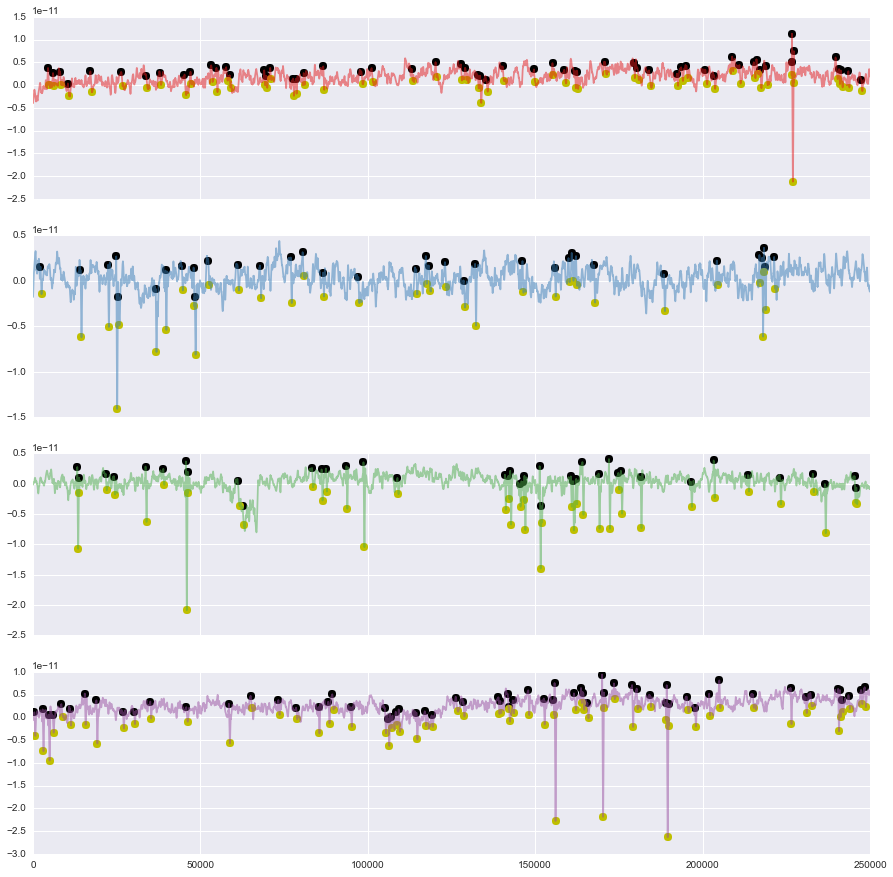

In [43]:
length=250000
colors = sns.color_palette('Set1', len(smooth))
fig, ax = plt.subplots(nrows=len(smooth), figsize=(15,15), sharex=True, sharey=False)
for i in range(len(Peaks_locations_list)):
    ax[i].plot(loc_sig_delta_values[i][loc_sig_delta_values[i]<length], smooth[i][loc_sig_delta_values[i]][loc_sig_delta_values[i]<length], 'o', color='k', markersize=8) # start values   
    ax[i].plot(new_peaks_locations_list[i][new_peaks_locations_list[i]< length], smooth[i][new_peaks_locations_list[i]][new_peaks_locations_list[i]< length], 'o', color='y', markersize=8) # peak values
    ax[i].plot(smooth[i][:length], color=colors[i],alpha=0.5)

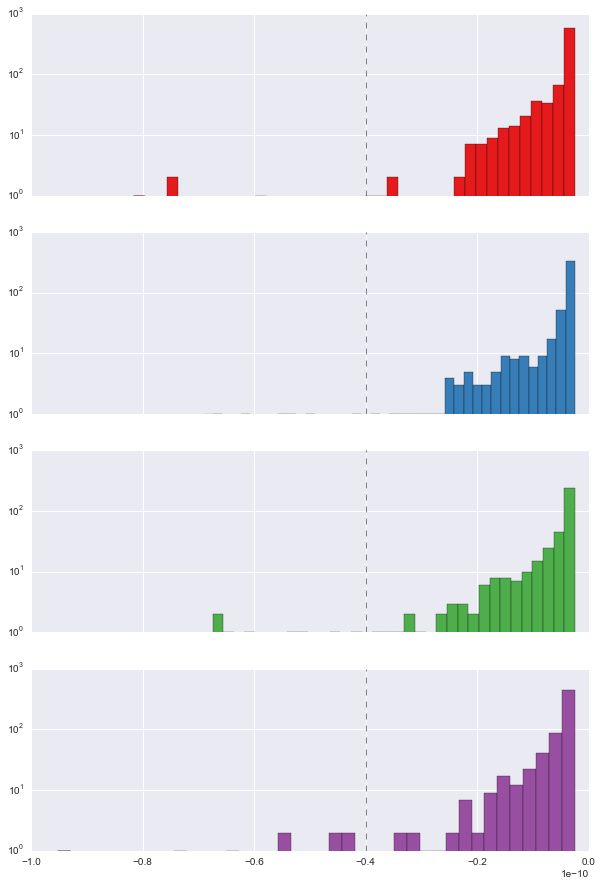

In [30]:
def hist_plotter(Values, bins=40):
    colors = sns.color_palette('Set1', len(Values))
    fig, ax = plt.subplots(nrows=len(Values), figsize=(10,15), sharex=True, sharey=True)
    for i in range(len(Values)):
        ax[i].hist(Values[i], bins, color=colors[i], log=True)
        ax[i].axvline(-40e-12, color='k',  alpha=0.5, linewidth=1, linestyle='--' );
        
hist_plotter(sig_delta_values)

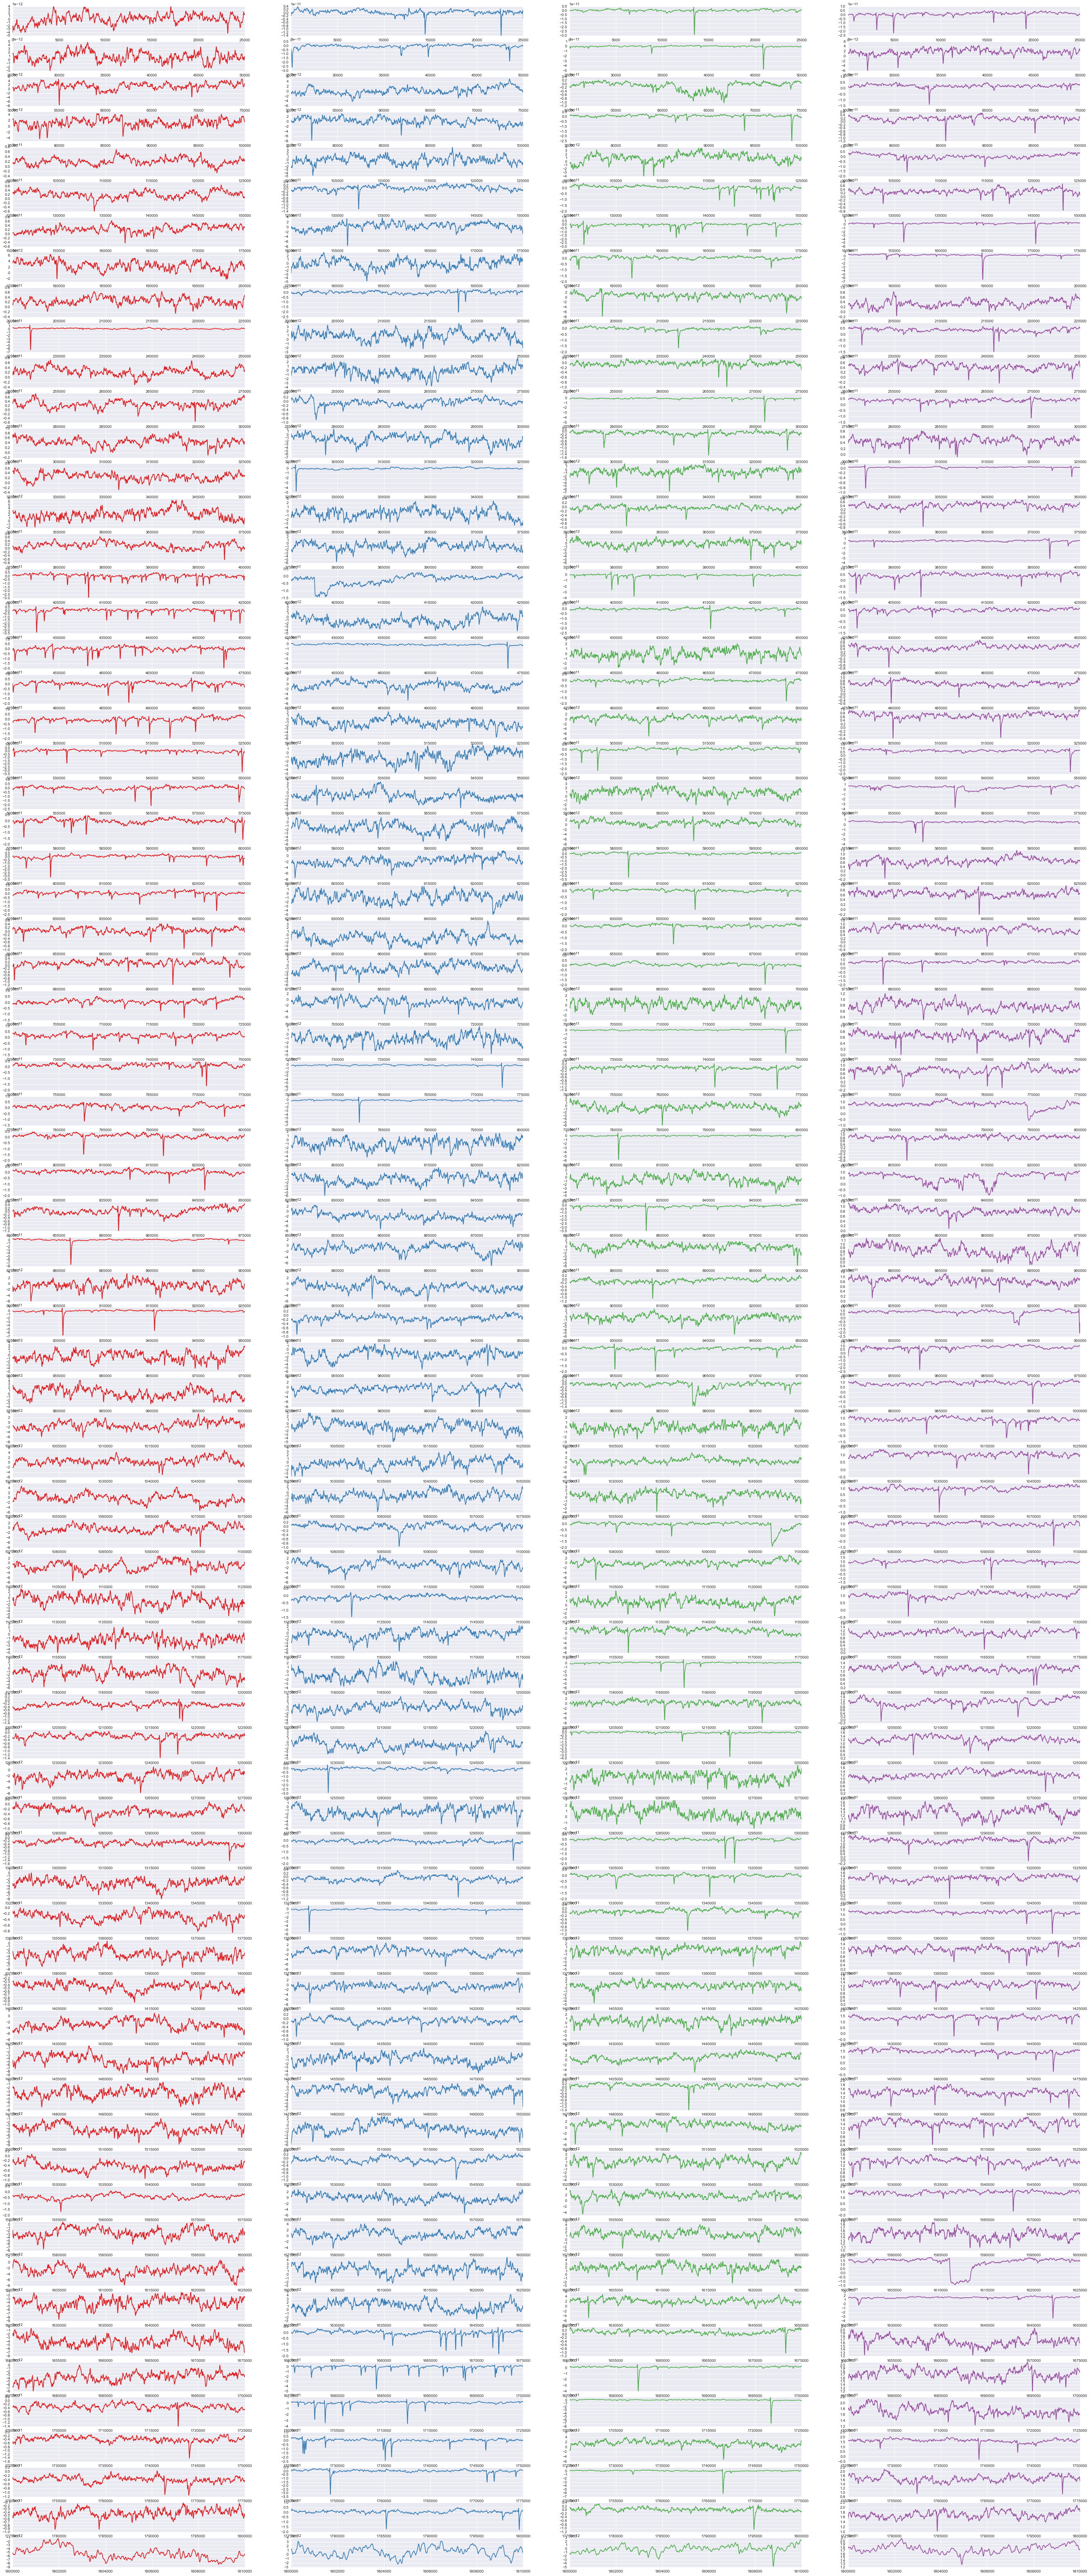

In [25]:
def period_plotter(traces, period=25000):
    colors = sns.color_palette('Set1', len(traces))
    number_of_plots=(len(traces[0])//period)+1
    fig, ax = plt.subplots(nrows=number_of_plots, ncols=len(traces), figsize=(50,120))
    for trace in range(len(traces)):
        multiplyer=0
        for i in range (number_of_plots):
            ax[i,trace].plot(np.array(range(period*multiplyer, period*multiplyer+len(traces[trace][period*multiplyer:period*(multiplyer+1)]))),traces[trace][period*multiplyer:period*(multiplyer+1)], color=colors[trace])
            multiplyer+=1

    
period_plotter(smooth)